In [ ]:
# colab specific commands
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!git clone https://github.com/microsoft/cf-ode.git
!git clone https://github.com/uber/causalml.git

In [ ]:
# required packages
!pip install pyro
!pip install pytorch_lightning
!pip install causalml
!pip install causalode
!pip install torch
!pip install numpy
!pip install scipy
!pip install pandas
!pip install torchdiffeq
!pip install torchsde
!pip install azureml
!pip install azureml.core
!pip install wandb
!pip install pyyaml==5.4.1

# Covid (Dexamethasone) Experiment

In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch

os.chdir("/content/cf-ode")
from causalode import covid_data_utils
os.chdir("/content")
from causalode.models import VariationalSDE
from causalml.inference.nn import CEVAE
from causalml.metrics import *

## Preparing Dexamethasone data

In [ ]:
X, X_static, T, Y_fact, Y_cf, p, k_Dex, t_X, t_Y = covid_data_utils.create_covid_data(t_span= 1, t_treatment= 0.5, N= 1000, gamma = 0, seed = 4221, noise_std = 0)

X = X.numpy() #feature matrix (15x2)
X_static = X_static.numpy() # ?
T = T.numpy() #indicator if treated or not
Y_fact = Y_fact.numpy() #factual outcomes
Y_cf = Y_cf.numpy() #counterfactual outcomes
p = p.numpy() # probability of recieving treatment (0.5 for all)
k_Dex = k_Dex.numpy() # ?
t_X = t_X.numpy() #timestamps of feature observations
t_Y = t_Y.numpy() #timestamps of outcome observations

#train(75%) test(25%) split
def train_test(x):
    train_idx = np.arange(len(X))[:int(0.75*len(X))]
    val_idx = np.arange(len(X))[int(0.75*len(X)):]
    x_train = x[train_idx]
    x_test = x[val_idx]
    return x_train, x_test

X_train, X_test = train_test(X)
T_train, T_test = train_test(T)
Y_train, Y_test = train_test(Y_fact)

#true treatment effects
tau = Y_fact - Y_cf
tau_train, tau_test = train_test(tau)

### Training

In [ ]:
entity = "chalberg" #entity for WandB logger
%cd /content/cf-ode/causalode
!python train_model.py --N_ts=1000 --batch_size=64 --ODE_mode=True --gpu=0 --continuous_treatment_ode=True --exact_iptw=False --continuous_treatment=True --dataset_name=covid --embedding_dim=64 --gamma=10 --horizon=10 --kl_param=0.001 --logger_type=wandb --max_epochs=500 --num_samples=5 --propensity_scores=False --seed=43 --sigma_sde=0.1 --std_dev=False --variational=True --entity=entity

### Evaluation

In [4]:
#imports
import matplotlib.pyplot as plt
import scipy
import numpy as np
import os

os.chdir("/content/cf-ode")
from causalode import models, data_utils, covid_data_utils
from causalode.utils import str2bool
os.chdir("/content")

#loading the trained model
import wandb
api = wandb.Api()

artifact = api.artifact('chalberg/causalode/model-1bz31430:v0', type="model")
artifact = artifact.download()

model_cls = models.VariationalSDE
model = model_cls.load_from_checkpoint("/content/artifacts/model-1bz31430:v0/model.ckpt")

hparams = dict(model.hparams)

#evaluating on test set
dataset_cls = covid_data_utils.CovidDataModule
dataset = dataset_cls(**hparams)
dataset.prepare_data()

model.eval()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb:   1 of 1 files downloaded.  


Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning
Warning


VariationalSDE(
  (encoder): GRU(2, 146, num_layers=2, batch_first=True)
  (out_encoder): Linear(in_features=146, out_features=64, bias=True)
  (treatment_embedding): Embedding(2, 64)
  (decoder): ContinuousTreatmentODE(
    (h_fun): Sequential(
      (0): Linear(in_features=65, out_features=65, bias=True)
      (1): MCDropout(p=0.0, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=65, out_features=65, bias=True)
      (4): MCDropout(p=0.0, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=65, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=64, bias=True)
    )
    (u_fun): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=False)
      (1): MCDropout(p=0.0, inplace=False)
      (2): ReLU()
      (3): Linear(in_features=64, out_features=64, bias=False)
      (4): MCDropout(p=0.0, inplace=False)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=False)
      (7): MCDropout(p=0

In [5]:
def update_dict(main_dict, new_dict):
    for key in new_dict.keys():
        main_dict[key].append(new_dict[key])

Y_og_dict = {}
Y_ood_dict = {}

Y_og_list = []
Y_ood_list = []

repeats = 10

with torch.no_grad():
    for i,batch in enumerate(dataset.test_dataloader()):
        X,Y, T, Y_cf, p, thetas_0, t_X, t_Y = batch
        times = torch.arange(11).float()

        Y_hat_list = []
        for _ in range(repeats):
            Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times)
            Y_hat_list.append(Y_hat[...,None])

        Y_hat_samples = torch.cat(Y_hat_list,-1)
        break

    X_ood = torch.rand(X.shape) # generating random features
    T_ood = T.clone() # same treatment policy

    Y_hat_list_ood = []
    for _ in range(repeats):
        Y_hat_ood, reg, logqp = model(X_ood,T_ood,return_decoded_u=True, times=times)
        Y_hat_list_ood.append(Y_hat_ood[...,None])

    Y_hat_samples_ood = torch.cat(Y_hat_list_ood,-1)

Y_og_list.append(Y_hat_samples)
Y_ood_list.append(Y_hat_samples_ood)

Y_og_dict["Covid"] = Y_og_list
Y_ood_dict["Covid"] = Y_ood_list

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [6]:
ood_dict = {}
og_dict ={}
Y_og_list = Y_og_dict["Covid"]
Y_ood_list = Y_ood_dict["Covid"]
for i in range(len(Y_og_list)):
  std_og = np.array([Y_og_list[i][0,:,:,:,:].std([-1,-2]).mean() for i in range(len(Y_og_list))])
  std_ood = np.array([Y_ood_list[i][0,:,:,:,:].std([-1,-2]).mean() for i in range(len(Y_ood_list))])
    
  ood_dict["Covid"] = std_ood / std_og.mean()
  og_dict["Covid"] = std_og / std_og.mean()

Text(0.5, 1.0, 'Comparison of uncertainty levels between in and out of distribution data')

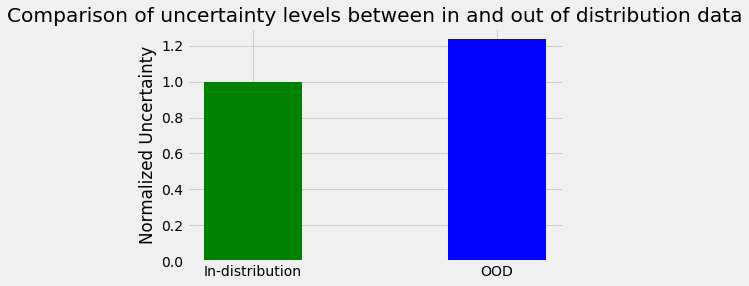

In [7]:
og_vec = std_og / std_og.mean()

ood_vec = std_ood / std_og.mean()

plt.bar([0.25,1.25],[og_dict["Covid"].mean(), ood_dict["Covid"].mean()],
        yerr=[og_dict["Covid"].std(), ood_dict["Covid"].std()],
        width = 0.4, color = ["green","blue"])
plt.xticks([0.25,1.25],["In-distribution","OOD"])
plt.ylabel("Normalized Uncertainty")
plt.title("Comparison of uncertainty levels between in and out of distribution data")

In [8]:
path = "chalberg/causalode/1bz31430"
run = api.run(path)

# Validation PEHE
val_pehe = run.summary["Val PEHE"]
val_pehe

0.046259138733148575

Text(0.5, 1.0, 'Comparison of RMSE between factual and counterfactual estimates')

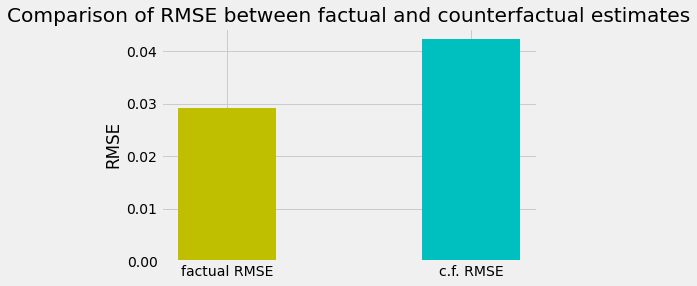

In [9]:
# RMSE comparison
val_rmse = run.summary["val_rmse"]
val_rmse_cf = run.summary["val_rmse_cf"]

plt.bar([0.25,1.25],[val_rmse, val_rmse_cf],
        width = 0.4, color = ["y","c"])
plt.xticks([0.25,1.25],["factual RMSE","c.f. RMSE"])
plt.ylabel("RMSE")
plt.title("Comparison of RMSE between factual and counterfactual estimates")

In [11]:
repeats = 10
model.eval()

Y_hat_samples_list = []
Y_alea_std_list = []
Y_hat_cf_samples_list = []
Y_alea_std_cf_list = []
Y_list = []
Y_cf_list = []
p_list = []
T_list = []
X_list = []

with torch.no_grad():
    for i,batch in enumerate(dataset.test_dataloader()):
        X,Y, T, Y_cf, p, thetas_0, t_X, t_Y = batch
        Y_list.append(Y)
        Y_cf_list.append(Y_cf)
        p_list.append(p)
        T_list.append(T)
        X_list.append(X)
        times = torch.arange(11).float()
        times_eval = torch.linspace(0,11, steps=11).float()
    
        Y_hat_list = []
        Y_hat_cf_list = []
        Y_alea_std = []
        Y_alea_cf_std = []
        for _ in range(repeats):
            Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times_eval)
            
            if model.std_dev:
                Y_hat, Y_std = torch.chunk(Y_hat,2,-1)
            else:
                Y_std = torch.zeros_like(Y_hat)
            
            Y_hat_list.append(Y_hat)
            Y_alea_std.append(torch.sqrt(torch.sigmoid(Y_std)))
            
            T_cf = (~T.bool()).float()
            Y_hat_cf, reg, logqp = model(X,T_cf,return_decoded_u=True, times=times_eval)
            
            if model.std_dev:
                Y_hat_cf, Y_std_cf = torch.chunk(Y_hat_cf,2,-1)
            else:
                Y_std_cf = torch.zeros_like(Y_hat_cf)
            
            Y_hat_cf_list.append(Y_hat_cf)
            Y_alea_cf_std.append(torch.sqrt(torch.sigmoid(Y_std_cf)))
            
        Y_hat_samples = torch.cat(Y_hat_list,0)
        Y_alea_std = torch.cat(Y_alea_std,0)
        Y_hat_cf_samples = torch.cat(Y_hat_cf_list,0)
        Y_alea_std_cf = torch.cat(Y_alea_cf_std,0)
        
        Y_hat_samples_list.append(Y_hat_samples)
        Y_alea_std_list.append(Y_alea_std)
        Y_hat_cf_samples_list.append(Y_hat_cf_samples)
        Y_alea_std_cf_list.append(Y_alea_std_cf)

Y_hat_samples = torch.cat(Y_hat_samples_list,1)
Y_alea_std = torch.cat(Y_alea_std_list,1)
Y_hat_cf_samples = torch.cat(Y_hat_cf_samples_list,1)
Y_alea_std_cf = torch.cat(Y_alea_std_cf_list,1)

Y = torch.cat(Y_list,0)
Y_cf = torch.cat(Y_cf_list,0)
p = torch.cat(p_list,0)
T = torch.cat(T_list,0)
X = torch.cat(X_list,0)

tensor(1.)
torch.Size([250, 10, 1])


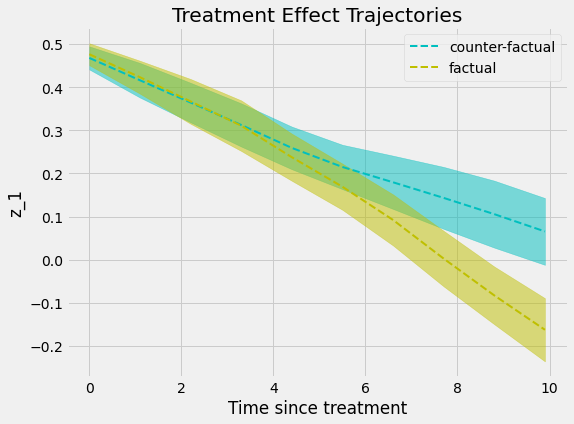

In [44]:
series_idx = 6
lim_left = 15
lim_left_continuous = 15
times_eval = torch.linspace(0,11,steps=11).float()
left_mask = times_eval[:-1]<=lim_left_continuous

print(T[series_idx]) # treatment status of individual being plotted

plt.figure(figsize=(8,6))
Y_hat_mean = Y_hat_samples.mean(0)
Y_hat_std  = Y_hat_samples.std(0)

Y_hat_up = (Y_hat_samples+0*1.96*Y_alea_std).max(0)[0]
Y_hat_down = (Y_hat_samples-0*1.96*Y_alea_std).min(0)[0]
Y_hat_diff = (Y_hat_up - Y_hat_down)

Y_hat_diff = 1.96*Y_hat_samples.std(0)
Y_hat_up = Y_hat_samples.mean(0) - Y_hat_diff
Y_hat_down = Y_hat_samples.mean(0) + Y_hat_diff

Y_hat_cf_mean = Y_hat_cf_samples.mean(0)
Y_hat_cf_std  = Y_hat_cf_samples.std(0)

Y_hat_cf_up = (Y_hat_cf_samples+0*1.96*Y_alea_std_cf).max(0)[0]
Y_hat_cf_down = (Y_hat_cf_samples-0*1.96*Y_alea_std_cf).min(0)[0]
Y_hat_cf_diff = Y_hat_cf_up - Y_hat_cf_down

Y_hat_cf_diff = 1.96*Y_hat_cf_samples.std(0)
Y_hat_cf_up = Y_hat_cf_samples.mean(0) - Y_hat_cf_diff
Y_hat_cf_down = Y_hat_cf_samples.mean(0) + Y_hat_cf_diff
print(Y_hat_cf_down.shape)

#plot std of predictions
plt.fill_between(times_eval[:-1][left_mask],
                 Y_hat_cf_down[series_idx][left_mask].reshape(-1),
                 Y_hat_cf_up[series_idx][left_mask].reshape(-1),
                 color = "c", label = "std of predictions", alpha=0.5)
plt.fill_between(times_eval[:-1][left_mask],
                 Y_hat_down[series_idx][left_mask].reshape(-1),
                 Y_hat_up[series_idx][left_mask].reshape(-1),
                 color = "y", alpha=0.5)

#plot means of predicitons
plt.plot(times_eval[:-1][left_mask],Y_hat_cf_mean[series_idx][left_mask], color = "c", linestyle = "--",linewidth = 2)
plt.plot(times_eval[:-1][left_mask],Y_hat_mean[series_idx][left_mask], label = "factual mean", color = "y", linestyle = "--",linewidth = 2)

plt.legend(["counter-factual","factual"], loc="upper right")
plt.title("Treatment Effect Trajectories")
plt.xlabel("Time since treatment")
plt.ylabel("z_1")

plt.show()

# IHADP Experiment

In [46]:
import pandas as pd
import numpy as np
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseSRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')

In [ ]:
# load all ihadp data
df = pd.DataFrame()
for i in range(1, 10):
    data = pd.read_csv('/content/drive/MyDrive/causal_inf_experiments/data/ihdp_npci_' + str(i) + '.csv', header=None)
    df = pd.concat([data, df])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df.columns = cols
print(df.shape)

# replicate the data 100 times
replications = 100
df = pd.concat([df]*replications, ignore_index=True)
print(df.shape)

# set which features are binary, else continuous
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

df = df.reset_index(drop=True)

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values

#true treatment effect
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

#train-test split
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

In [224]:
# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

In [ ]:
# fit
losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

In [ ]:
# predict
ite_val = cevae.predict(X_val)

### S Learner

In [48]:
# fit propensity model
p_model = ElasticNetPropensityModel()
p_train = p_model.fit_predict(X_train, treatment_train)
p_val = p_model.fit_predict(X_val, treatment_val)

# train and predict
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X_train, treatment_train, y_train)[0]
s_ite_val = s_learner.predict(X_val)

### Evaluation

In [50]:
preds_dict_valid = {}

preds_dict_valid['Actuals'] = tau_val

preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'treatment': treatment_val,
    'y_cf': y_cf_val,
    'tau': tau_val,
    'mu_0': mu_0_val,
    'mu_1': mu_1_val}

preds_dict_valid['CEVAE'] = ite_val.flatten()
preds_dict_valid['S Learner'] = s_ite_val.flatten()
actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl

#summary table
df_preds_validation = pd.DataFrame([#preds_dict_valid['CEVAE'].ravel(),
                               preds_dict_valid["S Learner"].ravel(),
                               preds_dict_valid['generated_data']['tau'].ravel(),
                               preds_dict_valid['generated_data']['mu_0'].ravel(),
                               preds_dict_valid['generated_data']['mu_1'].ravel()],
                               index= ['CEVAE','S Learner','tau','mu_0','mu_1']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]

In [51]:
synthetic_summary_validation

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,4.774991,0.000000,0.000000,0.000000,NaN
S Learner,4.690676,79.589272,0.017658,0.312504,0.683782
